# Logistic Regression - Titanic Example

 In this notebook explore prediction tasks where the response variable is categorical instead of numeric and look at a common classification technique known as logistic regression. We apply this technique to a data_set containing survival data for the passengers of the Titanic.

As part of the analysis, we will be doing the following:
Data extraction : we'll load the dataset and have a look at it.
Cleaning : we'll fill in some of the missing values.
Plotting : we'll create several charts that will (hopefully) help identify correlations and other insights

Two datasets are available: a training set and a test set. We'll be using the training set to build our predictive model and the testing set to evaluate it.

In [142]:
# import useful modules 
import pandas as pd
from pandas import DataFrame
import re
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except:
    !pip install seaborn
    
# import machine learning modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.learning_curve import learning_curve
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [101]:
sns.set_style('whitegrid')

In [102]:
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

Let us start by loading the training set and having a first look at our data:

## Data Gathering

In [103]:
training_data = pd.read_csv("train.csv")
test_data  = pd.read_csv("test.csv")

training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [104]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data Cleaning

In [105]:
print(training_data.info())
print("\n=======================================\n")
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-nul

The <b>Survived</b> column is our target/dependent/reponse variable, 1 means the passenger survived, 0 means that the passenger died. 

Several other variables describe the passengers:
- PassengerId: and id given to each traveler on the boat.
- Pclass: the passenger class. It has three possible values: 1,2,3.
- Name
- Sex
- Age
- SibSp: number of siblings and spouses traveling with the passenger
- Parch: number of parents and children traveling with the passenger
- The ticket number
- The ticket fare
- The cabin number
- The port of embarkation. It has three possible values S,C,Q. (C = Cherbourg; Q = Queenstown; S = Southampton) 

Let us check which records in the training data are missing information for the Embarked field. 

In [106]:
draw_missing_data_table(training_data)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [107]:
draw_missing_data_table(test_data)

,Total,Percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [108]:
# check the missing data for the Embarked field
training_data[training_data.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Let's look at the survival chances depending on the port of embarkation

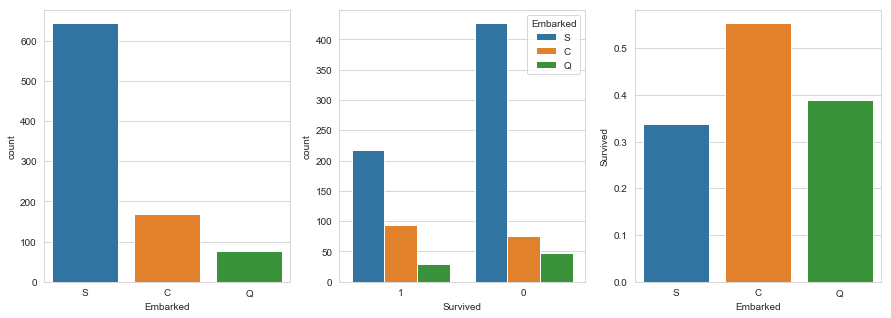

In [109]:
# plot
#sns.factorplot('Embarked','Survived', data=training_data,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=training_data, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=training_data, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = training_data[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

Lets look at other variables that may indicate where passengers embarked the ship.

In [110]:
training_data.loc[training_data.Ticket == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [111]:
print( 'C == ' + str( len(training_data.loc[training_data.Pclass == 1].loc[training_data.Fare > 75].loc[training_data.Fare < 85].loc[training_data.Embarked == 'C']) ) )
print( 'S == ' + str( len(training_data.loc[training_data.Pclass == 1].loc[training_data.Fare > 75].loc[training_data.Fare < 85].loc[training_data.Embarked == 'S']) ) )

C == 16
S == 13


In [112]:
training_data = training_data.set_value(training_data.Embarked.isnull(), 'Embarked', 'C')

c:\users\ashto\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


In [113]:
training_data.loc[training_data.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Let us check which records are missing information for the Fare and Cabin fields

In [114]:
test_data[test_data.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Let's visualize a histogram of the fares paid by the 3rd class passengers who embarked in Southampton.

Text(0.5,1,'Histogram of Fare, Plcass 3 and Embarked S')

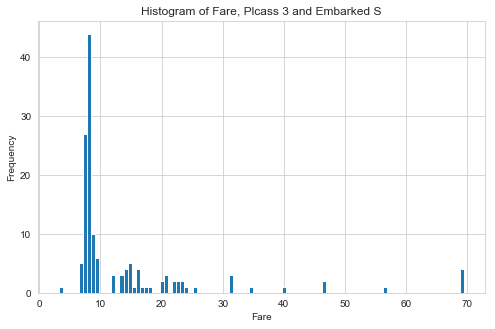

In [115]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

test_data[(test_data.Pclass==3)&(test_data.Embarked=='S')].Fare.hist(bins=100, ax=ax)
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Fare, Plcass 3 and Embarked S')

In [116]:
print ("The top 5 most common fares")
test_data[(test_data.Pclass==3)&(test_data.Embarked=='S')].Fare.value_counts().head()

The top 5 most common fares


8.0500    17
7.8958    10
7.7750    10
8.6625     8
7.8542     8
Name: Fare, dtype: int64

Let us fill in the missing values with the most common fare, $8.05

In [117]:
test_data.set_value(test_data.Fare.isnull(), 'Fare', 8.05)
test_data.loc[test_data.Fare.isnull()]

c:\users\ashto\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Let's look at the field of <b>Age</b> in the training dataset, and see how it correlates with survival.

In [118]:
test_data.loc[test_data.Age.isnull()].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S
29,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S


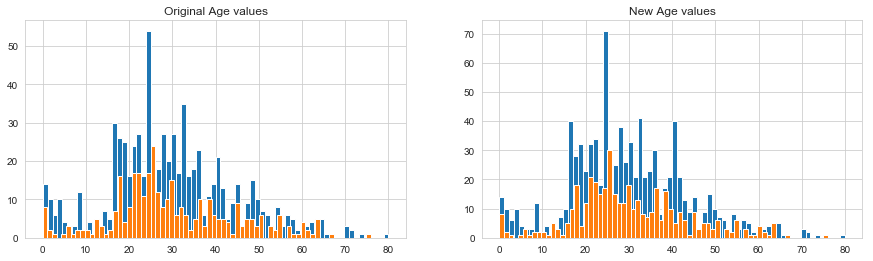

In [119]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values')
axis2.set_title('New Age values')

average_age_training   = training_data["Age"].mean()
std_age_training       = training_data["Age"].std()
count_nan_age_training = training_data["Age"].isnull().sum()

average_age_test   = test_data["Age"].mean()
std_age_test       = test_data["Age"].std()
count_nan_age_test = test_data["Age"].isnull().sum()

rand_1 = np.random.randint(average_age_training - std_age_training,\
                           average_age_training + std_age_training,\
                           size = count_nan_age_training)
rand_2 = np.random.randint(average_age_test - std_age_test,\
                           average_age_test + std_age_test,\
                           size = count_nan_age_test)

training_data['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
test_data['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

training_data.loc[np.isnan(training_data["Age"]), "Age"] = rand_1
test_data.loc[np.isnan(test_data["Age"]), "Age"] = rand_2

training_data['Age'] = training_data['Age'].astype(int)
test_data['Age']    = test_data['Age'].astype(int)    

training_data['Age'].hist(bins=70, ax=axis2)
test_data['Age'].hist(bins=70, ax=axis2)

c:\users\ashto\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


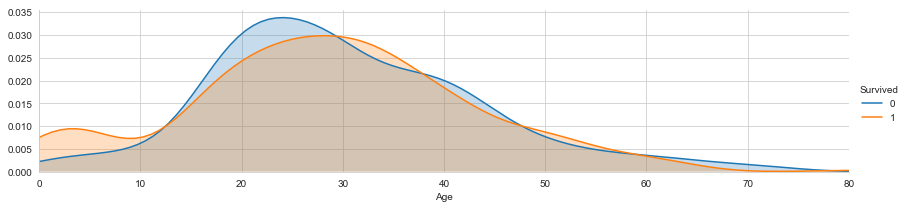

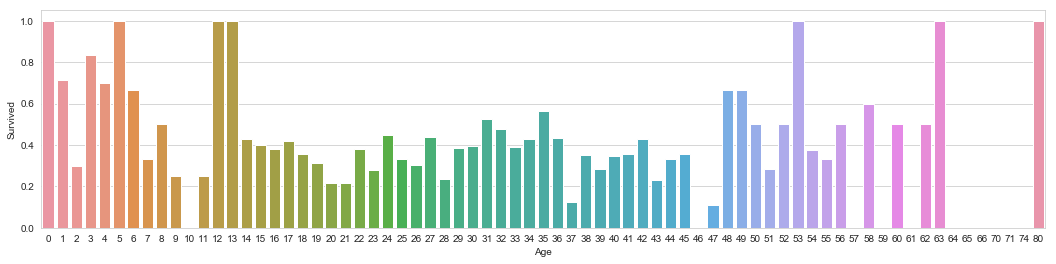

In [120]:
facet = sns.FacetGrid(training_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, training_data['Age'].max()))
facet.add_legend()

fig, axis1 = plt.subplots(1,1,figsize=(18,4))

average_age = training_data[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()

sns.barplot(x='Age', y='Survived', data=average_age)

In [121]:
draw_missing_data_table(training_data)

,Total,Percent
Cabin,687,0.771044
Embarked,0,0.000000
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Age,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [122]:
draw_missing_data_table(test_data)

,Total,Percent
Cabin,327,0.782297
Embarked,0,0.000000
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Age,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


Logically, does having cabin number without reference to any other information regarding the cabin help us? What if we had other information, say another table that told us where in the ship relative to the iceberg it was?

Since it doesn't tell us anything meaningful and there is no other feature we can use it in conjunction with, we can remove it.

In [123]:
training_data.drop(['Cabin'], axis=1, inplace=True)
test_data.drop(['Cabin'], axis=1, inplace=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,15,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,C


In [124]:
draw_missing_data_table(training_data)

,Total,Percent
Embarked,0,0.0
Fare,0,0.0
Ticket,0,0.0
Parch,0,0.0
SibSp,0,0.0
Age,0,0.0
Sex,0,0.0
Name,0,0.0
Pclass,0,0.0
Survived,0,0.0


In [125]:
draw_missing_data_table(test_data)

,Total,Percent
Embarked,0,0.0
Fare,0,0.0
Ticket,0,0.0
Parch,0,0.0
SibSp,0,0.0
Age,0,0.0
Sex,0,0.0
Name,0,0.0
Pclass,0,0.0
PassengerId,0,0.0


## Feature Engineering

The names have a prefix that, in some cases, is indicative of the social status, which may have been be an important factor in surviving the accident.
Braund, Mr. Owen Harris
Heikkinen, Miss. Laina
Oliva y Ocana, Dona. Fermina
Peter, Master. Michael J

Extracting the passenger titles and storring them in an additional column called <b>Title</b>.

In [126]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Nobel",
                    "Don":        "Nobel",
                    "Sir" :       "Nobel",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Nobel",
                    "Dona":       "Nobel",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Nobel"
                    } 

training_data['Title'] = training_data['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])
test_data['Title'] = test_data['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])

training_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,Mr
5,6,0,3,"Moran, Mr. James",male,29,0,0,330877,8.4583,Q,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,S,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,S,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,S,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,C,Mrs


Add a field FamilySize that aggregates the information in the fields indicating the presence of a partner (Parch) or a relative (SibSp).

In [127]:
training_data['FamilySize'] = training_data['SibSp'] + training_data['Parch']
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']

training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,Mr,0


The gender of pasanger is an important factor in surviving the accident. So is a pasenger's age.  Let us introduce a new feature to take into account the gender and age of passengers.

In [128]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
training_data['Person'] = training_data[['Age','Sex']].apply(get_person,axis=1)
test_data['Person']    = test_data[['Age','Sex']].apply(get_person,axis=1)

training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,Mr,1,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,Mrs,1,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,Miss,0,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,Mrs,1,female
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,Mr,0,male


In [129]:
training_data.info()
print("\n------------------------------------\n")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null int32
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
Title          891 non-null object
FamilySize     891 non-null int64
Person         891 non-null object
dtypes: float64(1), int32(1), int64(6), object(6)
memory usage: 94.1+ KB

------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null int32
SibSp          418 non

Let us select just the features of interest. We are dropping features like Name, SibSp and Sex, whose information is either no longer needed or is accounted for in the columns that we have added.

In [130]:
training_data.drop(labels=['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Sex'], axis=1, inplace=True)
test_data.drop(labels=['Name', 'Ticket', 'SibSp', 'Parch', 'Sex'], axis=1, inplace=True)

In [131]:
training_data.head()

,Survived,Pclass,Age,Fare,Embarked,Title,FamilySize,Person
0,0,3,22,7.2500,S,Mr,1,male
1,1,1,38,71.2833,C,Mrs,1,female
2,1,3,26,7.9250,S,Miss,0,female
3,1,1,35,53.1000,S,Mrs,1,female
4,0,3,35,8.0500,S,Mr,0,male


We use the information available on passengers to build a statistical model for survivorship, which, given a "new" passenger will predict whether or not he survived. There is a wide variety of models to use, from logistic regression to decision trees and more sophisticated ones such as random forests.


First, let us use Pandas' get_dummies function to encode some of the features with discrete values, i.e., Person, Embarked, Title and Pclass and add those dummy variables as columns to the DataFrame object that stores the training data.

In [132]:
dummies_person_train = pd.get_dummies(training_data['Person'],prefix='Person')
dummies_embarked_train = pd.get_dummies(training_data['Embarked'], prefix= 'Embarked') 
dummies_title_train = pd.get_dummies(training_data['Title'], prefix= 'Title')
dummies_pclass_train = pd.get_dummies(training_data['Pclass'], prefix= 'Pclass')

training_data = pd.concat([training_data, dummies_person_train, dummies_embarked_train, dummies_title_train, dummies_pclass_train], axis=1)
training_data = training_data.drop(['Person','Embarked','Title', 'Pclass'], axis=1)

training_data.head()

,Survived,Age,Fare,FamilySize,Person_child,Person_female,Person_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Nobel,Title_Officer,Pclass_1,Pclass_2,Pclass_3
0,0,22,7.2500,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
1,1,38,71.2833,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
2,1,26,7.9250,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
3,1,35,53.1000,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
4,0,35,8.0500,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1


In [133]:
dummies_person_test   = pd.get_dummies(test_data['Person'],prefix='Person')
dummies_embarked_test = pd.get_dummies(test_data['Embarked'], prefix= 'Embarked') 
dummies_title_test    = pd.get_dummies(test_data['Title'], prefix= 'Title')
dummies_pclass_test   = pd.get_dummies(test_data['Pclass'], prefix= 'Pclass')

test_data = pd.concat([test_data, dummies_person_test, dummies_embarked_test, dummies_title_test, dummies_pclass_test], axis=1)
test_data = test_data.drop(['Person','Embarked','Title', 'Pclass'], axis=1)

test_data.head()

,PassengerId,Age,Fare,FamilySize,Person_child,Person_female,Person_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Nobel,Title_Officer,Pclass_1,Pclass_2,Pclass_3
0,892,34,7.8292,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
1,893,47,7.0000,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
2,894,62,9.6875,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
3,895,27,8.6625,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
4,896,22,12.2875,2,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


## Modelling

Let us create a function that visualizes the accuracy of the models we are building. It plots as a continuous line the mean values of the scores of the chosen estimator for two data sets, and a coloured band around the mean line, i.e., the interval (mean - standard deviation, mean + standard deviation).

plot_learning_curve() uses in turn the function sklearn.learning_curve.learning_curve(), which determines cross-validated training and test scores for different training set sizes. An (optional) cross-validation generator splits the given dataset k times in training and test data. (The default is 3-fold cross validation.) Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. The scores are averaged over all k runs for each training subset size.

In [134]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

Let us build a model for the Titanic data. First, let us split the training data set into training and validation datasets, with the validation dataset being 30% of the data.  We are using sklearn.model_selection.train_test_split() which splits arrays or matrices into random train and validation, "test", subsets.

In [103]:
# import machine learning modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
try:
    from sklearn.model_selection import train_test_split
except:
    from sklearn.cross_validation import train_test_split
try:
    from sklearn.model_selection import GridSearchCV
except:
    from sklearn.grid_search import GridSearchCV
try:
    from sklearn.model_selection import learning_curve
except:
    from sklearn.learning_curve import learning_curve

In [135]:
X = training_data.drop(['Survived'], axis=1)
y = training_data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)

We will use GridSearchCV, which exhaustively considers all parameter combinations, to find the best model for the data. A search consists of:
- an estimator (regressor or classifier such as RandomForestClassifier(), or LogisticRegression());
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; 
- a score function, such as accurracy_score()



In [105]:
# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# make_scorer returns a callable object that scores an estimator’s output.
#We are using accuracy_score for comparing different parameter combinations. 
acc_scorer = make_scorer(accuracy_score)

# Run the grid search for the Random Forest classifier
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set our classifier, clf, to the have the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the selected classifier to the training data
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

For cross validation we are using the sklearn.model_selection.KFold(), a K-folds cross-validator which provides training and validation/testing indices to split data into training and validation (or testing) sets. KFold() splits a dataset into k consecutive folds with each fold used once as a validation while the k - 1 remaining folds form the training set.

0.794776119403


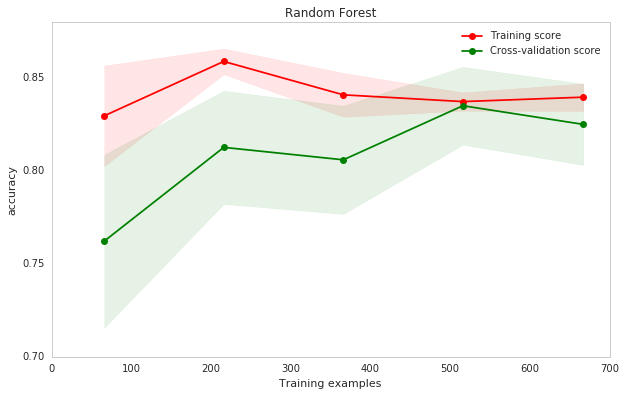

In [106]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))
plot_learning_curve(clf, 'Random Forest', X, y, cv=4);

In [136]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    
    #run KFold with 10 folds instead of the default 3
    #on the 891 records in the training_data
    kf = KFold(891, n_folds=10)
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

Let's repeat the above procedure for the logistic regression. Find the "best" Logistic Regression classifier: 

In [137]:
lg = LogisticRegression(random_state=42)
parameters = {'C': [0.1, 0.5, 1], 
              'penalty': ['l1', 'l2'], 
             }

run_kfold(lg)
# Use classification accuracy to compare parameter combinations
acc_scorer_lg = make_scorer(accuracy_score)

# Run a grid search for the Logistic Regression classifier and all the selected parameters
grid_obj_lg = GridSearchCV(lg, parameters, scoring=acc_scorer_lg)
grid_obj_lg = grid_obj_lg.fit(X_train, y_train)

# Set our classifier, lg, to have the best combination of parameters
lg = grid_obj_lg.best_estimator_

# Fit the selected classifier to the training data. 
lg.fit(X_train, y_train)

Fold 1 accuracy: 0.8
Fold 2 accuracy: 0.8651685393258427
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.8651685393258427
Fold 5 accuracy: 0.797752808988764
Fold 6 accuracy: 0.7865168539325843
Fold 7 accuracy: 0.7865168539325843
Fold 8 accuracy: 0.797752808988764
Fold 9 accuracy: 0.8876404494382022
Fold 10 accuracy: 0.8539325842696629
Mean Accuracy: 0.8226966292134831


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Plot the mean accuracy, the "learning curve", of the classifier on both the training and validation datasets.

0.8059701492537313


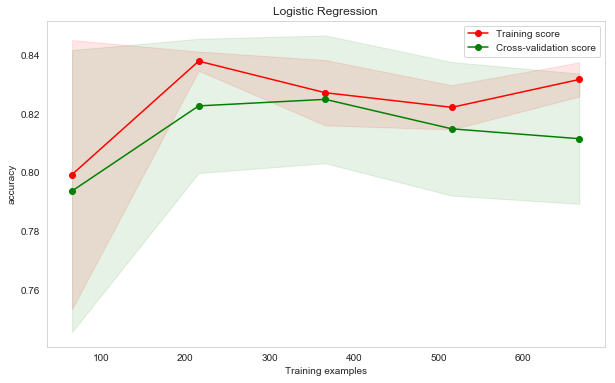

In [138]:
predictions_lg = lg.predict(X_test)
print(accuracy_score(y_test, predictions_lg))
plot_learning_curve(lg, 'Logistic Regression', X, y, cv=4);

Let's test our model on the unseen data (test set file) and make the confusion matrix!

In [146]:
real_results = pd.Series(y_test, name='Actual')
predicted_results = pd.Series(predictions_lg, name='Predicted')
confusion_matrix_df = pd.crosstab(real_results, predicted_results)
confusion_matrix_df

Predicted,0,1
Actual,,
0,22,20
1,17,14


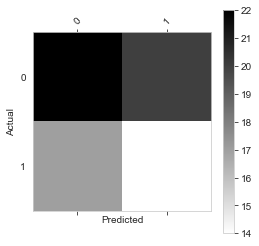

In [152]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.grid(False)

plot_confusion_matrix(confusion_matrix_df)

Finally, perform predictions on the reserved test dataset using the selected Random Forest classifier and store them in a file, titanic-predictions.csv.

In [153]:
ids = test_data['PassengerId']
predictions = lg.predict(test_data.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
